# 验证码的对抗与反对抗

## 验证码的前身今世
巴拉巴拉

## 实验思路
> * 验证码的破解
> * 验证码的对抗
> * 验证码的反对抗

In [ ]:
# 忽略警告
# import warnings
# warnings.filterwarnings('ignore')

In [ ]:
# GPU加速
# import keras.backend as K
# cfg = K.tf.ConfigProto()
# cfg.gpu_options.allow_growth = True
# K.set_session(K.tf.Session(config = cfg))

In [6]:
%matplotlib inline
from captcha.image import ImageCaptcha
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random, string
import cv2

# 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ
characters = string.digits + string.ascii_uppercase
width, height, n_len, n_class = 120, 60, 4, len(characters)
generator = ImageCaptcha(width=width, height=height)

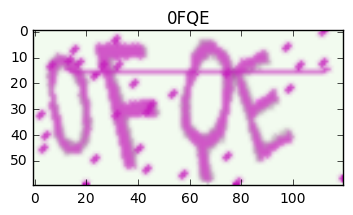

In [81]:
# test
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)
plt.figure(figsize = (4, 2))
plt.imshow(img)
plt.title(random_str)

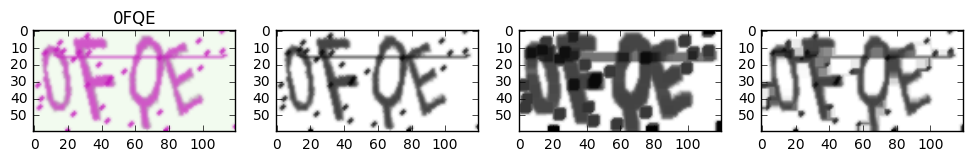

In [98]:
# 灰度
im = img.convert('L')
# 腐蚀、膨胀
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(np.array(im),kernel)
dilation = cv2.dilate(erosion,kernel,iterations = 1)
# dilation = cv2.dilate(np.array(im),kernel)
# erosion = cv2.erode(dilation,kernel,iterations = 1)

plt.figure(figsize = (12, 8))
plt.subplot(1, 4, 1)
plt.imshow(img, cmap='gray')
plt.title(random_str)
plt.subplot(1, 4, 2)
plt.imshow(im, cmap='gray')
plt.subplot(1, 4, 3)
plt.imshow(erosion, cmap='gray')
plt.subplot(1, 4, 4)
plt.imshow(dilation, cmap='gray')

## 灰度化和二值化[OpenCV P66]

### 简单阈值
但像素值高于阈值时，我们给这个像素
赋予一个新值（可能是白色），否则我们给它赋予另外一种颜色（也许是黑色）。

### 自适应阈值
此时的阈值是根据图像上的
每一个小区域计算与其对应的阈值。因此在同一幅图像上的不同区域采用的是
不同的阈值，从而使我们能在亮度不同的情况下得到更好的结果。
– cv2.ADPTIVE_THRESH_MEAN_C：阈值取自相邻区域的平
均值
– cv2.ADPTIVE_THRESH_GAUSSIAN_C：阈值取值相邻区域
的加权和，权重为一个高斯窗口。

### Otsu’s 二值化
简单来说就是对
一副双峰图像自动根据其直方图计算出一个阈值。（对于非双峰图像，这种方法
得到的结果可能会不理想）。

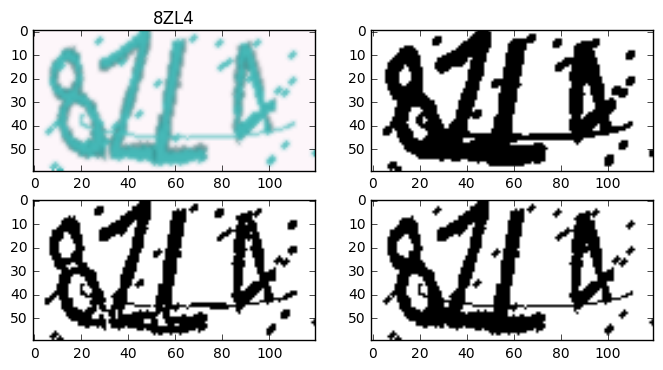

In [176]:
# gray = img.convert('L') # 灰度图 
# blur = gray.convert('1') # 二值化

# 灰度图
gray = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
# plt.imshow(gray, cmap='gray')

# 二值化
_, blur1 = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY)
# 自适应二值化
blur2 = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
# Otsu’s 二值化
_, blur3 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(figsize = (8, 4))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title(random_str)
plt.subplot(2, 2, 2)
plt.imshow(blur1, cmap='gray')
plt.subplot(2, 2, 3)
plt.imshow(blur2, cmap='gray')
plt.subplot(2, 2, 4)
plt.imshow(blur3, cmap='gray')

## 去噪操作[OpenCV P85]

### 中值滤波
顾名思义就是用与卷积框对应像素的中值来替代中心像素的值。

### 均值滤波
用卷积框覆盖区域所有像素的平均值来代替中心元素。

#### 高斯滤波
现在把卷积核换成高斯核（简单来说，方框不变，将原来每个方框的值是
相等的，现在里面的值是符合高斯分布的，方框中心的值最大，其余方框根据
距离中心元素的距离递减，构成一个高斯小山包。原来的求平均数现在变成求
加权平均数，全就是方框里的值）。

经测试，中值滤波效果最好。

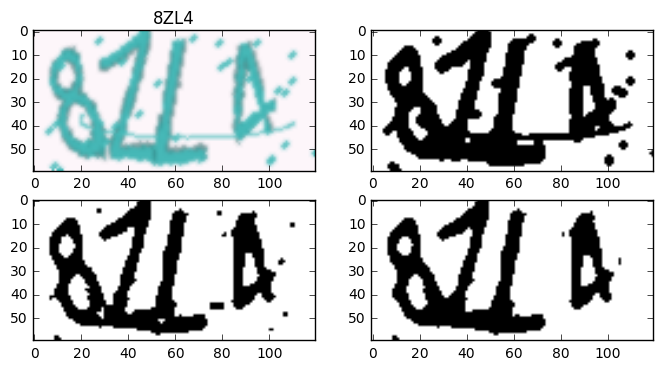

In [182]:
# 中值滤波
b1 = cv2.medianBlur(blur1, 3)
b2 = cv2.medianBlur(blur2, 5)
b3 = cv2.medianBlur(blur3, 5)
# 均值滤波
"""
b1 = cv2.blur(blur1, (5,5))
b2 = cv2.blur(blur2, (5,5))
b3 = cv2.blur(blur3, (5,5))
"""
# 高斯滤波
"""
b1 = cv2.GaussianBlur(blur1, (5,5),0)
b2 = cv2.GaussianBlur(blur2, (5,5),0)
b3 = cv2.GaussianBlur(blur3, (5,5),0)
"""

plt.figure(figsize = (8, 4))
plt.subplot(2, 2, 1)
plt.imshow(img, cmap='gray')
plt.title(random_str)
plt.subplot(2, 2, 2)
plt.imshow(b1, cmap='gray')
plt.subplot(2, 2, 3)
plt.imshow(b2, cmap='gray')
plt.subplot(2, 2, 4)
plt.imshow(b3, cmap='gray')

In [3]:
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    # X = np.zeros((batch_size, height, width, 1), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            # img = generator.generate_image(random_str)
            # 灰度图
            # img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2GRAY)
            # Otsu’s 二值化
            # _, img = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY)
            # 中值滤波
            # img = cv2.medianBlur(img, 5)
            # X[i] = img.reshape((height, width, 1))
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

In [4]:
def decode(y):
    acc = np.cumprod(np.max(y, axis=2)[0:])[-1]
    y = np.argmax(np.array(y), axis=2)[:,0]
    title = ''.join([characters[x] for x in y])
    return '%s %.6f' % (title, acc)

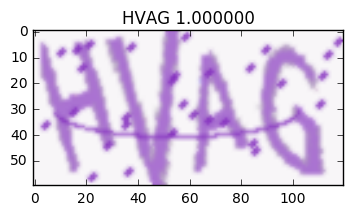

In [185]:
# test
X, y = next(gen(1))
plt.imshow(X[0], cmap='gray')
plt.title(decode(y))

In [137]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 1))
x = input_tensor
for i in range(3): # keras2
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
# 4个分类器多输出
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]

model = Model(inputs=input_tensor, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [138]:
from keras.utils import plot_model
from IPython.display import Image
# sudo pip install graphviz(安装接口)
# sudo apt-get install graphviz(安装软件本身)
# sudo pip install pydot
plot_model(model, to_file="model.png", show_shapes=True)
# Image('model.png')

In [139]:
model.fit_generator(gen(), steps_per_epoch=1000, epochs=10, workers=2, use_multiprocessing=True, 
                    validation_data=gen(), validation_steps=200) # keras2
# 多进程 workers=2, use_multiprocessing=True pickle_safe

/home/littleredhat/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:2057: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 999/1000 [============================>.] - ETA: 0s - loss: 8.1177 - c1_loss: 1.8741 - c2_loss: 1.9608 - c3_loss: 2.1036 - c4_loss: 2.1792 - c1_acc: 0.4817 - c2_acc: 0.4571 - c3_acc: 0.4192 - c4_acc: 0.4020

/home/littleredhat/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:2215: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 853s 853ms/step - loss: 8.1134 - c1_loss: 1.8727 - c2_loss: 1.9595 - c3_loss: 2.1028 - c4_loss: 2.1783 - c1_acc: 0.4821 - c2_acc: 0.4575 - c3_acc: 0.4194 - c4_acc: 0.4022 - val_loss: 2.4956 - val_c1_loss: 0.4658 - val_c2_loss: 0.5887 - val_c3_loss: 0.6680 - val_c4_loss: 0.7730 - val_c1_acc: 0.8481 - val_c2_acc: 0.8097 - val_c3_acc: 0.7961 - val_c4_acc: 0.7630
Epoch 2/10
1000/1000 [==============================] - 877s 877ms/step - loss: 2.2882 - c1_loss: 0.4454 - c2_loss: 0.5256 - c3_loss: 0.6445 - c4_loss: 0.6727 - c1_acc: 0.8591 - c2_acc: 0.8343 - c3_acc: 0.8027 - c4_acc: 0.7944 - val_loss: 1.4749 - val_c1_loss: 0.2785 - val_c2_loss: 0.3444 - val_c3_loss: 0.4145 - val_c4_loss: 0.4374 - val_c1_acc: 0.9125 - val_c2_acc: 0.8922 - val_c3_acc: 0.8742 - val_c4_acc: 0.8641
Epoch 3/10
1000/1000 [==============================] - 897s 897ms/step - loss: 1.5361 - c1_loss: 0.2964 - c2_loss: 0.3533 - c3_loss: 0.4414 - c4_loss: 0.4450 - c1_acc: 0.9083

KeyboardInterrupt: 

In [9]:
# save
model.save('captcha_model.h5')

In [1]:
from keras.models import load_model
model = load_model('captcha_model.h5')

Using TensorFlow backend.


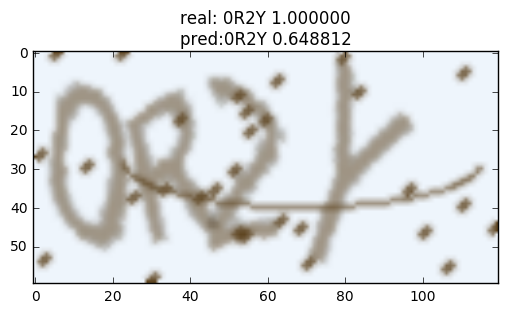

In [7]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')

In [72]:
from tqdm import tqdm
def evaluate(model, batch_num=100):
    batch_acc = 0
    for i in tqdm(range(batch_num)):
        X, y = next(gen(1))
        y_pred = model.predict(X)
        y_pred = np.argmax(y_pred, axis=2).T
        y_true = np.argmax(y, axis=2).T
        # batch_acc += np.mean(list(map(np.array_equal, y_true, y_pred))) # python3
        # mean 改 amin 因为要4个全对才算正确
        batch_acc += np.amin(list(map(np.array_equal, y_true, y_pred))) # python3
    return batch_acc / batch_num
evaluate(model)


100%|██████████| 100/100 [00:01<00:00, 62.08it/s]

0.82999999999999996

In [9]:
from keras import metrics
from keras.utils.np_utils import to_categorical
import keras.backend as K

def generate_adversarial(model, X):
    original_array  = np.array(X)
    target_idx      = np.argmax(model.predict(original_array), axis=2)[:,0]
    target          = to_categorical(target_idx, n_class)
    target_variable = K.variable(target)
    loss            = metrics.categorical_crossentropy(model.output, target_variable)
    gradients       = K.gradients(loss, model.input)
    # 训练和测试两种模式下不完全一致
    # 测试模式忽略Dropout层，BN层等组件
    # 需要在函数中传递一个learning_phase的标记 0训练/1测试
    get_grad_values = K.function([model.input, K.learning_phase()], gradients)
    grad_values     = get_grad_values([original_array, 0])[0]

    grad_signs      = np.sign(grad_values) # 取符号-1 +1 0
    epsilon         = 4
    perturbation    = grad_signs * epsilon
    modified_array  = original_array + perturbation
    deprocess_array = np.clip(modified_array, 0., 255.).astype(np.uint8) # 取值(0,255)
    return original_array, perturbation, deprocess_array

# def generate_titles(model, original_array, perturbation, deprocess_array):
# return title_original, title_perturbation, title_deprocess

def show(model, original_array, perturbation, deprocess_array):
    title_original = 'real: %s\npred:%s' % (decode(y), decode(model.predict(original_array)))
    title_perturbation = 'noise:\n%s' % decode(model.predict(perturbation))
    title_deprocess = 'adversarial:\n%s' % decode(model.predict(deprocess_array))
    
    plt.figure(figsize = (10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_array[0], cmap='gray')
    plt.title(title_original)

    ######
    plt.subplot(1, 3, 2)
    plt.imshow(perturbation[0], cmap='gray')
    plt.title(title_perturbation)

    ######
    plt.subplot(1, 3, 3)
    plt.imshow(deprocess_array[0], cmap='gray')
    plt.title(title_deprocess)

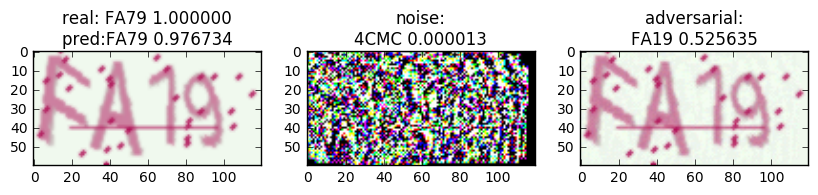

In [45]:
X, y = next(gen(1))
original_array, perturbation, deprocess_array = generate_adversarial(model, X)
show(model, original_array, perturbation, deprocess_array)

In [53]:
import os
from PIL import Image

def load_data(data_path):
    flist = os.listdir(test_path)
    flen = len(flist)
    X = np.zeros((flen, height, width, 3), dtype=np.uint8)
    y = np.zeros((flen, n_len), dtype=np.uint8)
    for i in range(flen):
        X[i] = Image.open(test_path + flist[i])
        for j, ch in enumerate(flist[i][0:4]):
            y[i][j] = characters.find(ch) # array([ 3,  8, 15, 11], dtype=uint8)
    return X, y, len(flist)

test_path = 'test/'
X, y, flen= load_data(test_path)

In [73]:
acc = 0
for i in tqdm(range(flen)):
    y_pred = model.predict(np.expand_dims(X[i], 0)) # (60, 120, 3)扩展到(60, 120, 3, 1)
    y_pred = np.argmax(y_pred, axis=2).T
    # acc += np.mean(list(map(np.array_equal, y[i], y_pred[0]))) # python3
    acc += np.amin(list(map(np.array_equal, y[i], y_pred[0]))) # python3
acc / flen


100%|██████████| 1000/1000 [00:13<00:00, 71.98it/s]

0.876

In [78]:
# 加入对抗后
acc = 0
for i in tqdm(range(100)):
    x = np.expand_dims(X[i], 0)
    _, _, deprocess_array = generate_adversarial(model, x)
    y_pred = model.predict(deprocess_array) # (60, 120, 3)扩展到(60, 120, 3, 1)
    y_pred = np.argmax(y_pred, axis=2).T
    acc += np.amin(list(map(np.array_equal, y[i], y_pred[0]))) # python3
acc / 100


  0%|          | 0/100 [00:00<?, ?it/s]
Exception in thread Thread-18:
Traceback (most recent call last):
  File "/home/littleredhat/anaconda3/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/littleredhat/anaconda3/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/littleredhat/anaconda3/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 100/100 [09:38<00:00,  5.78s/it]


0.050000000000000003

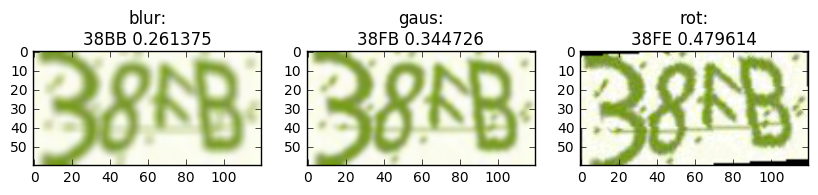

In [91]:
def decode_vcode(deprocess_array):
    plt.figure(figsize = (10, 5))
    ##### 均值滤波
    img_blur = cv2.blur(deprocess_array[0], (5,5))
    title_blur = 'blur:\n%s' % decode(model.predict(np.expand_dims(img_blur, 0)))
    plt.subplot(1, 3, 1)
    plt.imshow(img_blur, cmap='gray')
    plt.title(title_blur)

    ##### 高斯模糊
    img_gaus = cv2.GaussianBlur(deprocess_array[0], (5,5), 0)
    title_gaus = 'gaus:\n%s' % decode(model.predict(np.expand_dims(img_gaus, 0)))
    plt.subplot(1, 3, 2)
    plt.imshow(img_gaus, cmap='gray')
    plt.title(title_gaus)

    ##### 旋转对抗
    img_rot = Image.fromarray(deprocess_array[0]).rotate(3)
    title_rot = 'rot:\n%s' % decode(model.predict(np.expand_dims(img_rot, 0)))
    plt.subplot(1, 3, 3)
    plt.imshow(img_rot, cmap='gray')
    plt.title(title_rot)

_, _, deprocess_array = generate_adversarial(model, np.expand_dims(X[0], 0))
decode_vcode(deprocess_array)

In [85]:
# 以旋转作为反对抗后
acc = 0
for i in tqdm(range(100)):
    x = np.expand_dims(X[i], 0)
    _, _, deprocess_array = generate_adversarial(model, x)
    img_rot = Image.fromarray(deprocess_array[0]).rotate(3)
    y_pred = model.predict(np.expand_dims(img_rot, 0)) # (60, 120, 3)扩展到(60, 120, 3, 1)
    y_pred = np.argmax(y_pred, axis=2).T
    acc += np.amin(list(map(np.array_equal, y[i], y_pred[0]))) # python3
acc / 100

100%|██████████| 100/100 [13:30<00:00,  8.11s/it]


0.35999999999999999